In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import time

In [38]:
train_df = pd.read_csv('data/train_64f_somefill0.csv')
test_df = pd.read_csv('data/test_64f_somefill0.csv')

train_df.head()

,SK_ID_CURR,W_DEFAULT,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,AMT_LESS_MAX,DAYS_LATE_AVG,DAYS_LATE_MAX,SK_DPD_DEF,LESS_GRANTED,REJECTED_APPLICATIONS,AMT_CREDIT_SUM_TOTAL,AMT_CREDIT_SUM_DEBT_TOTAL,AMT_CREDIT_SUM_LIMIT_TOTAL,AMT_CREDIT_SUM_OVERDUE_TOTAL
0,100002,1.0,0,1,0,202500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0.000,20.421053,31.0,0.0,0.0,0.0,865055.565,245781.0,31988.565,0.0
1,100003,0.0,0,0,0,270000.0,State servant,Higher education,Married,House / apartment,...,0.000,7.160000,14.0,0.0,1.0,0.0,1017400.500,0.0,810000.000,0.0
2,100004,0.0,1,1,0,67500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0.000,7.666667,11.0,0.0,1.0,0.0,189037.800,0.0,0.000,0.0
3,100006,0.0,0,1,0,135000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,...,0.000,19.375000,77.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN
4,100007,0.0,0,1,0,121500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,22655.655,4.590909,31.0,0.0,2.0,0.0,146250.000,0.0,0.000,0.0


In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

categoricals = [
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE',
]
cols_to_scale = [
    'Avg_Monthly_Balance','Months_Fully_Paid', 
    'Months_Minimum_Paid', 'Months_Minimum_Paid', 
    'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
    'Age_Years','Employed_Months', 'AMT_LESS_TOTAL',
    'AMT_LESS_MAX', 'DAYS_LATE_MAX', 'SK_DPD_DEF',
    'AMT_CREDIT_SUM_TOTAL', 'AMT_CREDIT_SUM_DEBT_TOTAL',
    'AMT_CREDIT_SUM_LIMIT_TOTAL', 'AMT_CREDIT_SUM_OVERDUE_TOTAL',
    'Tenure_Months', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'DAYS_LAST_PHONE_CHANGE', 
]
others = train_df.columns.difference(categoricals + cols_to_scale)

preproc = ColumnTransformer([
    ('cat', OneHotEncoder(), categoricals),
    # ('scaled', MinMaxScaler(), cols_to_scale),
], remainder='passthrough')

In [ ]:
X = train_df.drop(columns='W_DEFAULT')
y = train_df['W_DEFAULT']

X = preproc.fit_transform(X)
# X[np.isnan(X)] = 0


In [41]:
# preprocess test data
X_submit = test_df.drop(columns='W_DEFAULT')
X_submit = preproc.transform(X_submit)
# X_submit[np.isnan(X_submit)] = 0

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, auc, make_scorer

def auc_prc(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_prc_score = make_scorer(auc_prc, needs_proba=True)

scoring = {
    'auc_prc': auc_prc_score, 
    'precision': make_scorer(precision_score), 
    'recall': make_scorer(recall_score),
    'mcc': make_scorer(matthews_corrcoef),
    'auc_roc': make_scorer(roc_auc_score, needs_proba=True)
}

In [43]:
# default xgb
from xgboost import XGBClassifier

baseline = XGBClassifier(objective='binary:logistic', eval_metric='auc')
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)
y_proba = baseline.predict_proba(X_test)

results = {}
results['XGBoost Default, 64 Features'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

pd.DataFrame.from_dict(results, orient='index')

,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
"XGBoost Default, 64 Features",0.478593,0.050048,0.09062,0.757338,0.30296,0.134601


In [59]:
from sklearn.model_selection import cross_validate

scores = cross_validate(baseline, X, y, scoring=scoring)
scores = {key: np.mean(values) for key, values in scores.items()}
results = {}
results['XGBoost Defaults, 64 Features'] = {
    'Precision': scores['test_precision'],
    'Recall': scores['test_recall'],
    'AUC PRC': scores['test_auc_prc'],
    'AUC ROC': scores['test_auc_roc'],
    'MCC': scores['test_mcc'],
    'Training Time': scores['fit_time']
}

pd.DataFrame.from_dict(results, orient='index')

/home/dyoung/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,AUC PRC,AUC ROC,MCC,Training Time
"XGBoost Defaults, 64 Features",0.341854,0.049184,0.231052,0.753144,0.107312,2.649016


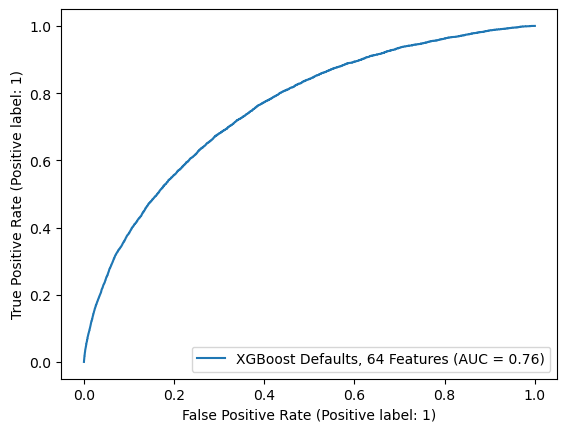

In [78]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_proba[:, 1], name='XGBoost Defaults, 64 Features')

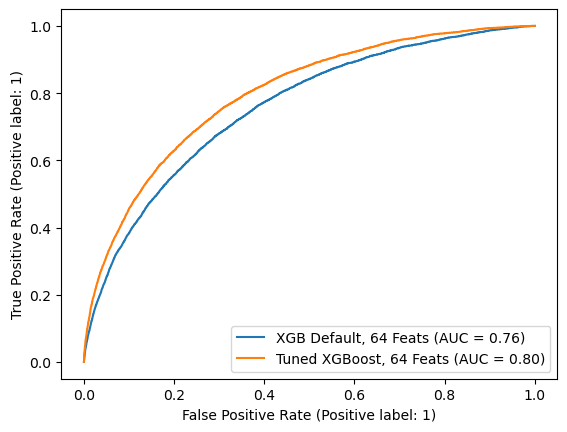

In [82]:
ax = plt.gca()
RocCurveDisplay.from_estimator(baseline, X_test, y_test, name='XGB Default, 64 Feats', ax=ax)
RocCurveDisplay.from_estimator(best_model, X_test, y_test, name='Tuned XGBoost, 64 Feats', ax=ax)

In [ ]:
# create submission file
y_submit_baseline = baseline.predict_proba(X_submit)
pd.Series(y_submit_baseline[:,1], index=test_df.SK_ID_CURR, name='TARGET').to_csv('submits/baseline_xgb_64.csv')

In [12]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(3, 10),
    'eta': Real(0.01, 0.5),
    'gamma': Real(0, 1),
    'min_child_weight': Real(1, 10),
    # 'scale_pos_weight': Real(1, 15),
    'max_delta_step': Real(1, 10),
    'colsample_bytree': Real(0.5, 1),
    'subsample': Real(0.5, 1),
    'lambda': Real(0.01, 10),
    'alpha': Real(0.01, 10),
}

model = XGBClassifier(objective='binary:logistic', eval_metric='auc')

opt = BayesSearchCV(
    model,
    param_space,
    # random_state=0,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)
# Record start time
start_time = time.time()
print(f"Model training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")


opt.fit(X_train, y_train)

# Record end time
end_time = time.time()

print(f"Model training ended at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

best_model = opt.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", opt.best_params_)
mean_fit_time = opt.cv_results_['mean_fit_time'][opt.best_index_]
std_fit_time = opt.cv_results_['std_fit_time'][opt.best_index_]
print(f'Mean training time of {mean_fit_time}, std of {std_fit_time}')

Model training started at: 2024-11-28 04:31:05
Model training ended at: 2024-11-28 04:40:15
Total Training Time: 550.46 seconds
Best Hyperparameters: OrderedDict([('alpha', 5.5691124921440665), ('colsample_bytree', 0.5), ('eta', 0.16489585328980133), ('gamma', 0.74592481207219), ('lambda', 0.01), ('max_delta_step', 10.0), ('max_depth', 4), ('min_child_weight', 10.0), ('n_estimators', 250), ('subsample', 1.0)])
Mean training time of 9.683560228347778, std of 0.0905846104009282


In [105]:
best_model = XGBClassifier(**opt.best_params_)
best_model.fit(X_train, y_train)

results = {}

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

results['XGBoost, 64 features'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

pd.DataFrame.from_dict(results, orient='index')

,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
"XGBoost, 64 features",0.537349,0.035657,0.066877,0.769064,0.325728,0.122888


In [109]:
from skopt import gp_minimize
from skopt.space import Real
def loss(threshold):
    y_threshed = y_proba[:,1] > threshold
    cm = confusion_matrix(y_test, y_threshed)

    fp = cm[0,1]
    fn = cm[1,0]
    return fp + fn * 6

minimize_result = gp_minimize(
    loss, [Real(0, 1)], n_calls=50, 
)

print(f'Best threshold found of {minimize_result.x} with loss of {minimize_result.fun}')

Best threshold found of [0.1417177471664711] with loss of 29212


In [110]:
thresh = minimize_result.x[0]
y_threshed = y_proba[:,1] > thresh
cm = confusion_matrix(y_test, y_threshed)

fp = cm[0,1]
fn = cm[1,0]
print(fp, fn)
print(f'NPL Rate of {cm[1,0]/(cm[1,0] + cm[0,0])}')

9064 3358
NPL Rate of 0.051726793801411014


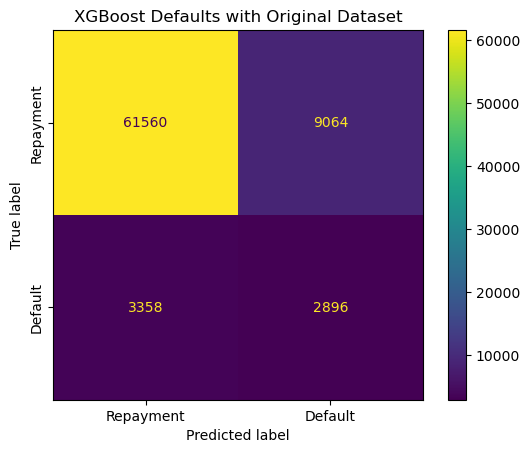

In [111]:
cm = confusion_matrix(y_test, y_threshed)

from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('XGBoost Defaults with Original Dataset');

In [94]:
scores = cross_validate(best_model, X, y, scoring=scoring)
scores = {key: np.mean(values) for key, values in scores.items()}
results = {}
results['XGBoost Tuned, 64 Features'] = {
    'Precision': scores['test_precision'],
    'Recall': scores['test_recall'],
    'AUC PRC': scores['test_auc_prc'],
    'AUC ROC': scores['test_auc_roc'],
    'MCC': scores['test_mcc'],
    'Training Time': scores['fit_time']
}

pd.DataFrame.from_dict(results, orient='index')

/home/dyoung/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,AUC PRC,AUC ROC,MCC,Training Time
"XGBoost Tuned, 64 Features",0.426623,0.034481,0.261448,0.773549,0.10594,10.839834


In [16]:
y_submit_tuned = best_model.predict_proba(X_submit)
pd.Series(y_submit_tuned[:,1], index=test_df.SK_ID_CURR, name='TARGET').to_csv('submits/tuned_xgb_64.csv')

In [91]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(3, 10),
    'eta': Real(0.01, 0.5),
    'gamma': Real(0, 1),
    'min_child_weight': Real(1, 10),
    'scale_pos_weight': Real(1, 50),
    'max_delta_step': Real(1, 10),
    'colsample_bytree': Real(0.5, 1),
    'subsample': Real(0.5, 1),
    'lambda': Real(0.01, 10),
    'alpha': Real(0.01, 10),
}

model = XGBClassifier(objective='binary:logistic', eval_metric='auc')

opt_weighted = BayesSearchCV(
    model,
    param_space,
    # random_state=0,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)
# Record start time
start_time = time.time()
print(f"Model training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")


opt_weighted.fit(X_train, y_train)

# Record end time
end_time = time.time()

print(f"Model training ended at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

best_model_weighted = opt_weighted.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", opt_weighted.best_params_)
mean_fit_time = opt_weighted.cv_results_['mean_fit_time'][opt_weighted.best_index_]
std_fit_time = opt_weighted.cv_results_['std_fit_time'][opt_weighted.best_index_]
print(f'Mean training time of {mean_fit_time}, std of {std_fit_time}')

Model training started at: 2024-11-29 05:20:42
Model training ended at: 2024-11-29 05:31:12
Total Training Time: 629.91 seconds
Best Hyperparameters: OrderedDict([('alpha', 10.0), ('colsample_bytree', 0.5), ('eta', 0.0692746603094231), ('gamma', 0.0), ('lambda', 0.01), ('max_delta_step', 3.639377939095392), ('max_depth', 7), ('min_child_weight', 10.0), ('n_estimators', 250), ('scale_pos_weight', 1.0), ('subsample', 0.7736907703391712)])
Mean training time of 16.72109785079956, std of 0.31732453293348317


In [92]:
best_model_weighted = XGBClassifier(**opt_weighted.best_params_)
best_model_weighted.fit(X_train, y_train)

results = {}

y_pred = best_model_weighted.predict(X_test)
y_proba = best_model_weighted.predict_proba(X_test)

results['XGBoost'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

pd.DataFrame.from_dict(results, orient='index')

,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
XGBoost,0.537859,0.032939,0.062076,0.768792,0.324734,0.118162


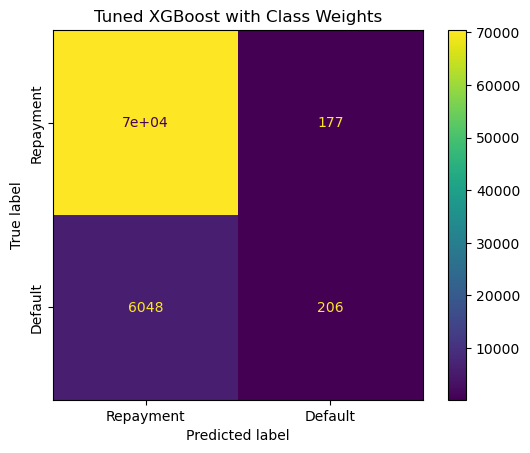

In [93]:
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('Tuned XGBoost with Class Weights');

In [20]:
y_submit_tuned_weighted = best_model_weighted.predict_proba(X_submit)
pd.Series(y_submit_tuned_weighted[:,1], index=test_df.SK_ID_CURR, name='TARGET').to_csv('submits/tuned_xgb_weighted_64.csv')

In [87]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy=0.3, random_state=1)
# in order to use ADASYN we must fill NA with 0s
from copy import deepcopy
X_train_filled = deepcopy(X_train)
X_train_filled[np.isnan(X_train_filled)] = 0
X_test_filled = deepcopy(X_test)
X_test_filled[np.isnan(X_test_filled)] = 0

X_adasyn, y_adasyn = adasyn.fit_resample(X_train_filled, y_train)

In [88]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(3, 10),
    'eta': Real(0.01, 0.5),
    'gamma': Real(0, 1),
    'min_child_weight': Real(1, 10),
    # 'scale_pos_weight': Real(1, 15),
    'max_delta_step': Real(1, 10),
    'colsample_bytree': Real(0.5, 1),
    'subsample': Real(0.5, 1),
    'lambda': Real(0.1, 10),
    'alpha': Real(0.1, 10),
}

model = XGBClassifier(objective='binary:logistic', eval_metric='auc')

opt_adasyn = BayesSearchCV(
    model,
    param_space,
    # random_state=0,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

# Record start time
start_time = time.time()
print(f"Model training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")
opt_adasyn.fit(X_adasyn, y_adasyn)

# Record end time
end_time = time.time()

print(f"Model training ended at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

best_model = opt_adasyn.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", opt_adasyn.best_params_)

Model training started at: 2024-11-29 05:01:03
Model training ended at: 2024-11-29 05:17:07
Total Training Time: 963.98 seconds
Best Hyperparameters: OrderedDict([('alpha', 10.0), ('colsample_bytree', 0.5), ('eta', 0.0835241695194503), ('gamma', 0.2173624445402278), ('lambda', 10.0), ('max_delta_step', 1.0), ('max_depth', 10), ('min_child_weight', 7.385716443628432), ('n_estimators', 250), ('subsample', 0.9450625926309895)])


,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
XGBoost + ADASYN,0.416561,0.052287,0.092911,0.734683,0.272972,0.124545


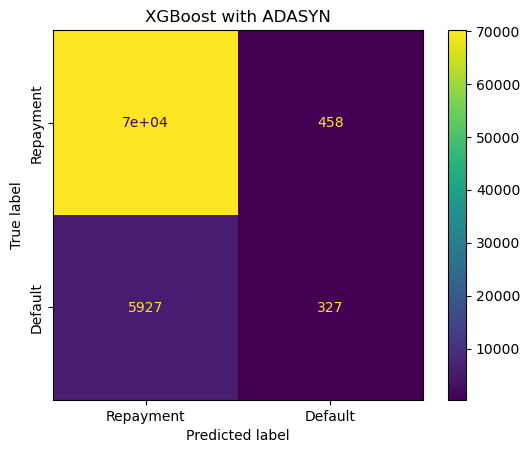

In [89]:
best_model_adasyn = XGBClassifier(**opt_adasyn.best_params_)
best_model_adasyn.fit(X_adasyn, y_adasyn)

results = {}

y_pred = best_model_adasyn.predict(X_test)
y_proba = best_model_adasyn.predict_proba(X_test)

results['XGBoost + ADASYN'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

display(pd.DataFrame.from_dict(results, orient='index'))

cm = confusion_matrix(y_test, y_pred)

# fig = plt.subplots(figsize=(5,5))
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('XGBoost with ADASYN');

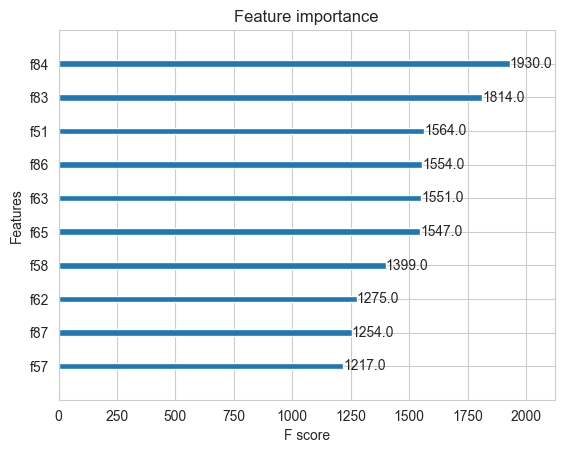

In [89]:
from xgboost import plot_importance
importance = best_model_adasyn.feature_importances_
plot_importance(best_model_adasyn, max_num_features=10, importance_type='weight')
plt.show()

In [ ]:
column_names = preproc.get_feature_names_out()
features = ['_'.join(name.split('_')[2:]) for name in column_names]

100%|===================| 230530/230633 [15:12<00:00]        

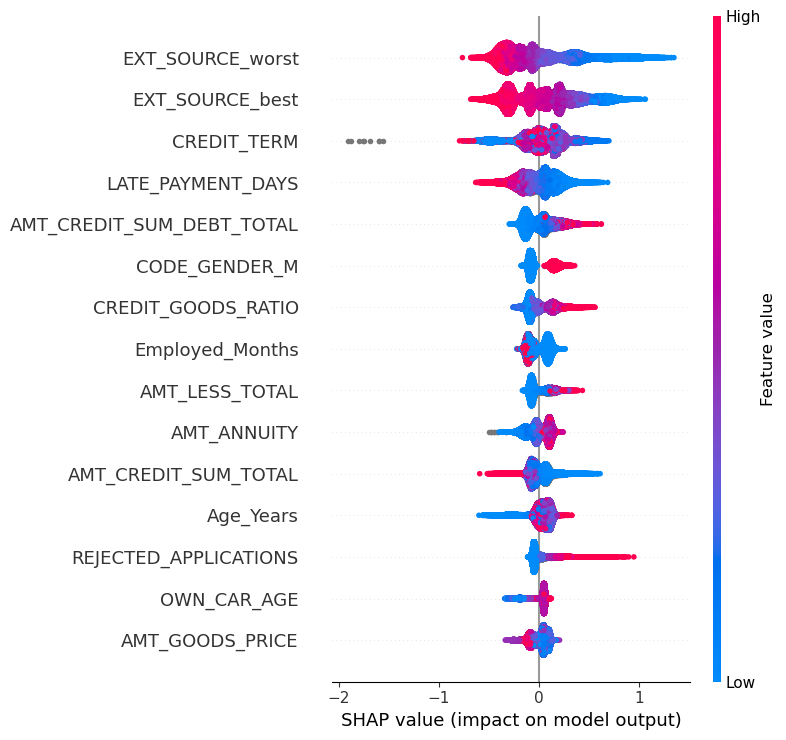

In [ ]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

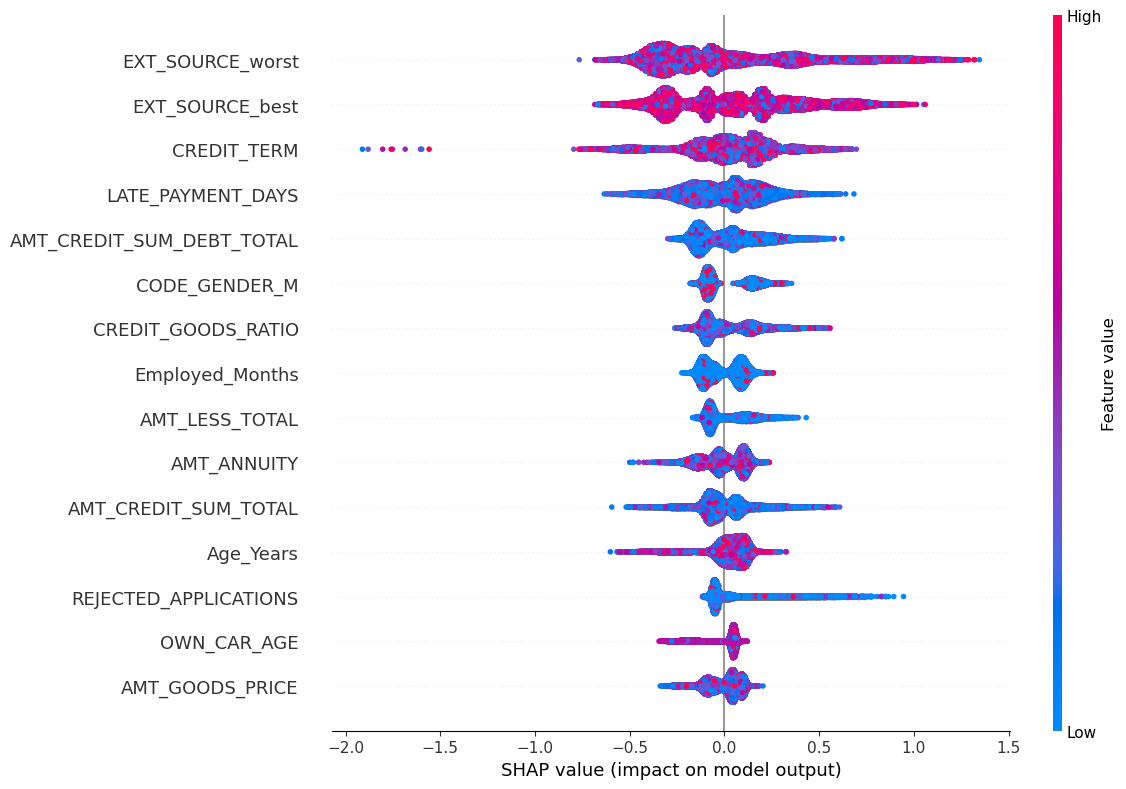

In [112]:
# Summary plot
shap.summary_plot(shap_values, X_train, feature_names=features, max_display=15, plot_size=(12,8))

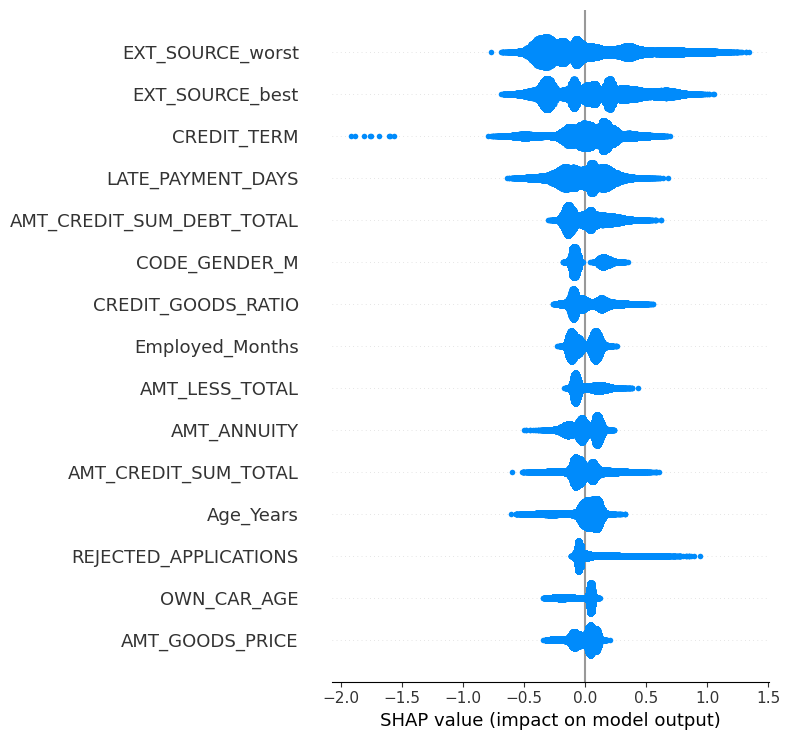

In [32]:
shap.summary_plot(shap_values, features, max_display=15)

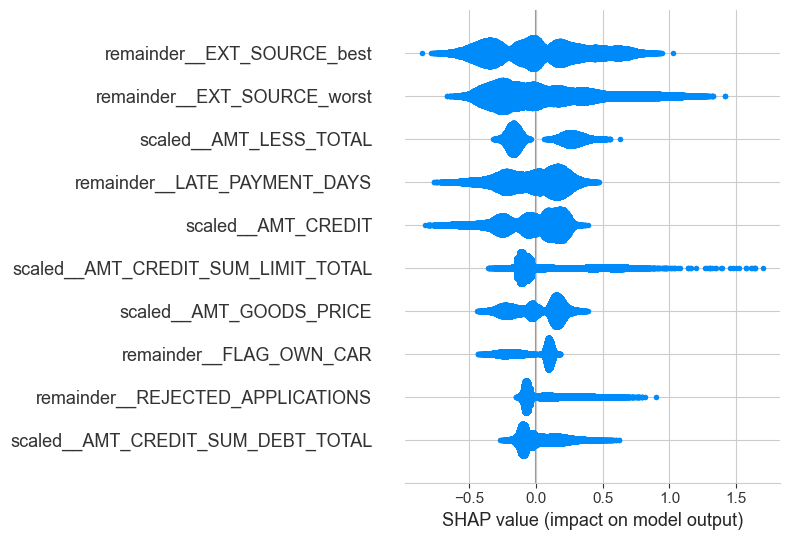

In [109]:
shap.summary_plot(shap_values, column_names, max_display=10)

In [35]:
shap_summary = pd.DataFrame({
    'Feature': features,
    'Mean SHAP Value': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='Mean SHAP Value', ascending=False)

shap_summary.head(15)


,Feature,Mean SHAP Value
93,EXT_SOURCE_worst,0.299253
92,EXT_SOURCE_best,0.274530
69,CREDIT_TERM,0.160164
95,LATE_PAYMENT_DAYS,0.148163
104,AMT_CREDIT_SUM_DEBT_TOTAL,0.123266
91,CODE_GENDER_M,0.111509
72,CREDIT_GOODS_RATIO,0.107046
90,Employed_Months,0.089279
96,AMT_LESS_TOTAL,0.087331
62,AMT_ANNUITY,0.086332
